In [27]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Open the csv file of actors
financials = pd.read_csv('./../cleaned_datasets/financial_data_no_budget.csv')
financials_bud = pd.read_csv('./../cleaned_datasets/financial_data.csv')
movies = pd.read_csv('./../cleaned_datasets/movies_clean.csv')

# 1. Data prep

In [67]:
data = financials_bud.merge(movies, left_on=["original_title", "year_release", "runtime"], right_on=["name", "year_release" , "runtime"], how='left')
data = data.drop(columns=["revenue", "name", 'wikipedia_id', 'freebase_id', 'release_date',
       'languages', 'countries', 'genres'])
data = data.dropna(subset=["revenue_final_adjusted" , "budget_adjusted", "averageRating"])
data = data[data['revenue_final_adjusted'] != 0]
data = data[data['revenue_final_adjusted'] >= 1000]
data["rev_per_bud"] = data["revenue_final_adjusted"] / data["budget_adjusted"]
data["log_rev"] = np.log(data["revenue_final_adjusted"])
data

,original_title,runtime,year_release,budget_adjusted,revenue_final_adjusted,averageRating,numVotes,average_award_cumcount,average_movies_cumcount,award_cumcount,movies_cumcount,rev_per_bud,log_rev
0,The Cheat,59.0,1915,173795,1379092,6.5,2709.0,0.000000,0.333333,0.0,3.0,7.935165,14.136936
7,The Unholy Three,86.0,1925,1034080,7067892,7.2,2117.0,0.000000,3.250000,0.0,26.0,6.834957,15.771073
13,Flesh and the Devil,112.0,1926,3744778,6606069,7.6,4533.0,0.000000,1.444444,0.0,13.0,1.764075,15.703499
17,Lights of New York,57.0,1928,752971,12047543,5.7,907.0,0.000000,2.000000,0.0,6.0,16.000009,16.304371
19,West of Zanzibar,65.0,1928,2600261,9246489,7.2,1915.0,0.250000,7.750000,1.0,31.0,3.555985,16.039754
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4588,Killing Them Softly,97.0,2012,19515604,49349062,6.2,150251.0,0.333333,8.533333,5.0,128.0,2.528698,17.714429
4595,Bachelorette,87.0,2012,3903120,15544769,5.3,48378.0,0.000000,6.000000,0.0,66.0,3.982652,16.559235
4598,The Cold Light of Day,93.0,2012,26020805,21940200,4.9,38954.0,0.076923,5.230769,1.0,68.0,0.843179,16.903831
4600,That's My Boy,116.0,2012,91072819,75536274,5.5,106484.0,0.000000,6.000000,0.0,90.0,0.829405,18.140124


# 2. Correlation Analysis

In [68]:
correlation = data[['averageRating', 'revenue_final_adjusted']].corr(method='pearson')
print(correlation)

correlation = data[['averageRating', 'revenue_final_adjusted']].corr(method='spearman')
print(correlation)

                        averageRating  revenue_final_adjusted
averageRating                 1.00000                 0.23622
revenue_final_adjusted        0.23622                 1.00000
                        averageRating  revenue_final_adjusted
averageRating                1.000000                0.250826
revenue_final_adjusted       0.250826                1.000000


Slight positive correlation

# 3. Scatter plot with regression line

In [69]:
fig = px.scatter(
    data, 
    x='averageRating', 
    y='revenue_final_adjusted', 
    trendline='ols', 
    title='Relationship between Rating and Revenue',
    labels={'averageRating': 'Average Rating', 'revenue_final_adjusted': 'Revenue (CPI Adjusted)'},
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.show()
#fig.write_html("plot.html")
#fig.write_image("plot.png")

# 4. Simple linear regression

could also add budget

In [70]:
X = data[['averageRating']]
y = data['revenue_final_adjusted']
X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(y, X).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     revenue_final_adjusted   R-squared:                       0.056
Model:                                OLS   Adj. R-squared:                  0.055
Method:                     Least Squares   F-statistic:                     103.4
Date:                    Mon, 11 Dec 2023   Prob (F-statistic):           1.21e-23
Time:                            12:52:45   Log-Likelihood:                -36556.
No. Observations:                    1752   AIC:                         7.312e+04
Df Residuals:                        1750   BIC:                         7.313e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const 

In [71]:
# Fit the model
X = data[['averageRating']]
y = data['revenue_final_adjusted']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()

# Extract coefficients
slope, intercept = model.params['averageRating'], model.params['const']

# Create scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['averageRating'], y=data['revenue_final_adjusted'], 
                         mode='markers', name='Data Points'))

# Add regression line
fig.add_trace(go.Scatter(x=data['averageRating'], y=intercept + slope * data['averageRating'], 
                         mode='lines', name='Regression Line'))

# Update layout
fig.update_layout(
    title='Regression Analysis: Rating vs. Revenue',
    xaxis_title='Average Rating',
    yaxis_title='Revenue (CPI Adjusted)'
)

# Optionally, add annotations with key statistics
# This is a basic example, you can format it as needed
fig.add_annotation(x=max(data['averageRating']), y=max(data['revenue_final_adjusted']),
                   text=f'R-squared: {model.rsquared:.2f}\n' +
                        f'Coefficient: {slope:.2f}',
                   showarrow=False, yshift=10)

fig.show()


In [72]:
# Define the independent variables (including budget) and the dependent variable
X = data[['averageRating', 'budget_adjusted']]
y = data['revenue_final_adjusted']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Build the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     revenue_final_adjusted   R-squared:                       0.317
Model:                                OLS   Adj. R-squared:                  0.317
Method:                     Least Squares   F-statistic:                     406.6
Date:                    Mon, 11 Dec 2023   Prob (F-statistic):          9.53e-146
Time:                            12:52:51   Log-Likelihood:                -36272.
No. Observations:                    1752   AIC:                         7.255e+04
Df Residuals:                        1749   BIC:                         7.257e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
co

In [73]:
# Fit the model
X = data[['averageRating']]
y = data['revenue_final_adjusted']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()

# Extract coefficients
slope, intercept = model.params['averageRating'], model.params['const']

# Create scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['averageRating'], y=data['revenue_final_adjusted'], 
                         mode='markers', name='Data Points'))

# Add regression line
fig.add_trace(go.Scatter(x=data['averageRating'], y=intercept + slope * data['averageRating'], 
                         mode='lines', name='Regression Line'))

# Update layout
fig.update_layout(
    title='Regression Analysis: Rating vs. Revenue',
    xaxis_title='Average Rating',
    yaxis_title='Revenue (CPI Adjusted)'
)

# Optionally, add annotations with key statistics
# This is a basic example, you can format it as needed
fig.add_annotation(x=max(data['averageRating']), y=max(data['revenue_final_adjusted']),
                   text=f'R-squared: {model.rsquared:.2f}\n' +
                        f'Coefficient: {slope:.2f}',
                   showarrow=False, yshift=10)

fig.show()


# 5. Residual Analysis

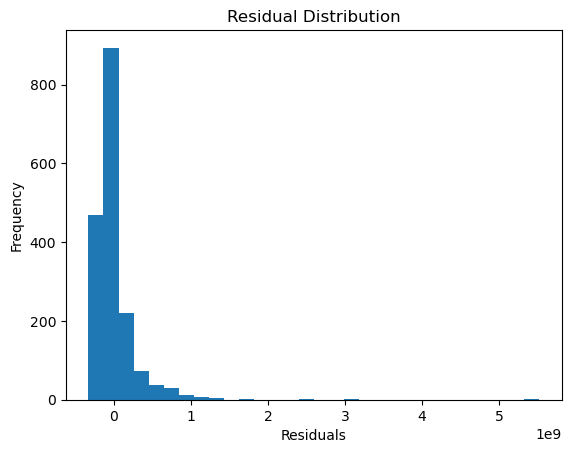

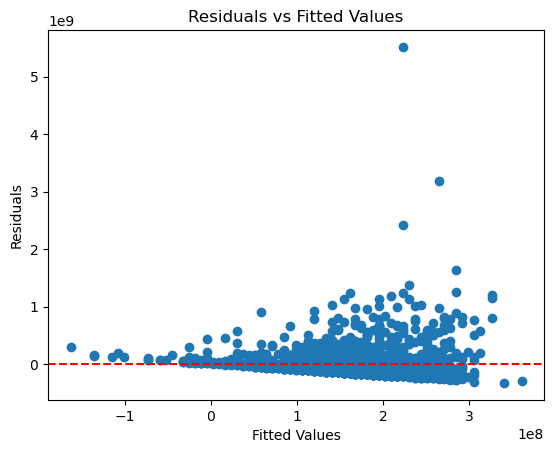

In [74]:
residuals = model.resid
plt.hist(residuals, bins=30)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Scatter plot for residuals
plt.scatter(model.predict(), residuals)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


# 6. Quartiles group comparison

In [75]:
quartiles = data['averageRating'].quantile([0.25, 0.5, 0.75])

# Function to categorize each movie based on its rating quartile
def rating_category(rating):
    if rating <= quartiles[0.25]:
        return 'Low'
    elif rating <= quartiles[0.5]:
        return 'Lower-Middle'
    elif rating <= quartiles[0.75]:
        return 'Upper-Middle'
    else:
        return 'High'

# Apply the function to create a new column for rating category
data['RatingCategory'] = data['averageRating'].apply(rating_category)

# Group by the new category and calculate mean revenue
average_revenues = data.groupby('RatingCategory')['revenue_final_adjusted'].mean()

# Display the results
print(average_revenues)

RatingCategory
High            2.717789e+08
Low             9.244641e+07
Lower-Middle    1.345948e+08
Upper-Middle    1.671323e+08
Name: revenue_final_adjusted, dtype: float64


In [83]:
# Apply the rating_category function to create a new column for rating category
data['RatingCategory'] = data['averageRating'].apply(rating_category)

# Calculate mean and standard deviation for each category
category_stats = data.groupby('RatingCategory')['revenue_final_adjusted'].agg(['mean', 'std'])

# Create the Plotly boxplot with specified category order
fig = px.box(data, x='RatingCategory', y='revenue_final_adjusted', 
             title="Boxplot of Revenue by Rating Category",
             labels={'revenue_final_adjusted': 'Revenue (CPI Adjusted) (log)', 'RatingCategory': 'Rating Category'},
             category_orders={"RatingCategory": ["Low", "Lower-Middle", "Upper-Middle", "High"]},
             points=None, color = "RatingCategory")
               # Turn off the display of max, min, and quartile markers

#fig.update_traces(hoverinfo='skip', hovertemplate=None)

# Update the layout to use a logarithmic scale for the y-axis
fig.update_layout(yaxis_type="log")


fig.show()


# 7. Pair matching / Propensity score

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.spatial.distance import cdist

# Assuming your DataFrame is named 'data'
# Let's say we define high ratings as being in the top 25% of your ratings

# Step 1: Define Treatment Group
high_rating_threshold = data['averageRating'].quantile(0.75)
data['high_rating'] = data['averageRating'] >= high_rating_threshold

# Step 2: Calculate Propensity Scores
# Selecting covariates that are predictors of receiving the treatment
covariates = data[['year_release', "budget_adjusted"]]  # You can add more covariates

# Logistic Regression to calculate propensity scores
model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(covariates, data['high_rating'], test_size=0.33, random_state=42)
model.fit(X_train, y_train)

# Predict Propensity Scores
data['propensity_score'] = model.predict_proba(covariates)[:, 1]

# Step 3: Match Movies
# We'll perform nearest neighbor matching
high_rated_movies = data[data['high_rating']]
low_rated_movies = data[~data['high_rating']]

# Calculate distances between all high and low rated movies
distances = cdist(high_rated_movies[['propensity_score']], low_rated_movies[['propensity_score']], metric='euclidean')

# For each high rated movie, find its closest low rated match
min_distances = np.argmin(distances, axis=1)
matched_movies = low_rated_movies.iloc[min_distances]

# Step 4: Compare Outcomes
# Compare average revenue between high rated movies and their matched pairs
average_revenue_high = high_rated_movies['revenue_final_adjusted'].mean()
average_revenue_matched = matched_movies['revenue_final_adjusted'].mean()

print(f"Average Revenue for High Rated Movies: {average_revenue_high}")
print(f"Average Revenue for Matched Low Rated Movies: {average_revenue_matched}")


Average Revenue for High Rated Movies: 261543669.4929006
Average Revenue for Matched Low Rated Movies: 118989880.41987829


In [19]:
import pandas as pd
import statsmodels.formula.api as smf
import networkx as nx

def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

# Assuming the DataFrame is named 'data'
# Standardize continuous features
data['budget_adjusted_std'] = (data['budget_adjusted'] - data['budget_adjusted'].mean()) / data['budget_adjusted'].std()
data['year_release_std'] = (data['year_release'] - data['year_release'].mean()) / data['year_release'].std()

# Define high rating
high_rating_threshold = data['averageRating'].quantile(0.75)
data['high_rating'] = (data['averageRating'] >= high_rating_threshold).astype(int)


# Calculate Propensity Scores
mod = smf.logit(formula='high_rating ~ budget_adjusted_std + year_release_std', data=data)
res = mod.fit()
data['Propensity_score'] = res.predict()

# Separate the treatment and control groups
treatment_df = data[data['high_rating'].astype(bool)]
control_df = data[~data['high_rating'].astype(bool)]

# Create a Network Graph
G = nx.Graph()

# Add edges with weights based on propensity score similarity
for control_idx, control_row in control_df.iterrows():
    for treatment_idx, treatment_row in treatment_df.iterrows():
        # Weight based on the inverse of the absolute difference in propensity scores
        weight = get_similarity(control_row['Propensity_score'],treatment_row['Propensity_score'])
        G.add_edge(control_idx, treatment_idx, weight=weight)

# Find the Maximum Weight Matching
matching = nx.max_weight_matching(G, maxcardinality=True)

# Extract matched indices into a flat list
matched_indices_flat = [idx for pair in matching for idx in pair]

# Use the flat list of indices to get the matched data
matched_data = data.loc[matched_indices_flat]

# Calculate and compare average revenues
average_revenue_high = matched_data[matched_data['high_rating'].astype(bool)]['revenue_final_adjusted'].mean()
average_revenue_low = matched_data[~matched_data['high_rating'].astype(bool)]['revenue_final_adjusted'].mean()

print(f"Average Revenue for High Rated Movies: {average_revenue_high}")
print(f"Average Revenue for Matched Low Rated Movies: {average_revenue_low}")

Optimization terminated successfully.
         Current function value: 0.565112
         Iterations 5
Average Revenue for High Rated Movies: 261543669.4929006
Average Revenue for Matched Low Rated Movies: 148953859.79918864
